In [1]:
import h5py
import numpy as np
import matplotlib
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [2]:
# each h5 file has 50 events
class_names = {
    "Other": np.inf,
    "Electron": 11,
    "Muon": 13,
    "Proton": 2212,
    "Neutron": 2112,
    "Charged Pion": 211,
    "Neutral Pion": 111,
    "Photon": 22
}

class_ids = np.asarray(list(class_names.values()))

NUMU_DIRECTORY = Path("/home/roblesee/dune/hpst/data/argon_cubic_production")
def open_numu_file(i):
    data_file = NUMU_DIRECTORY / f"argon_cubic_numu_production_{i}.h5"
    
    with h5py.File(data_file, 'r') as file:
        print(file["g4_data_0"].keys())
        cross_comp = file["g4_data_0"]["pdg"][:] == np.expand_dims(class_ids, axis=0)
        mask = cross_comp.any(axis=1)
        classes = cross_comp.argmax(axis=1)
        #classes[~mask] = 0
        coords = np.stack([file["g4_data_0"]["step_x"][:,0], file["g4_data_0"]["step_y"][:,0], file["g4_data_0"]["step_z"][:,0]], axis=-1)
        pid = file["g4_data_0"]["pid"][:,0]
        prongs = file["g4_data_0"]["tid"][:,0]
        edep = file["g4_data_0"]["step_edep"][:,0]
        t = file["g4_data_0"]["step_no"][:,0]
        evtid = file["g4_data_0"]["evtid"][:,0]
        
        print(t.min(), t.max())
    
        #mask = mask & (file["g4_data_0"]["evtid"][:,0] == evt_id)
        mask = (edep > 0.25)
        
        t = t[mask]
        classes = classes[mask]
        coords = coords[mask]
        prongs = prongs[mask]
        edep = edep[mask]
        evtid = evtid[mask]
        
        # TODO: don't use pandas as I think it's kind of slow, maybe pytorch is faster
        coords = (coords // np.asarray([[50,50,50]])).astype(np.int64)
        df = pd.DataFrame({
            "evtid": evtid,
            "x": coords[:,0], 
            "y": coords[:,1], 
            "z": coords[:,2],
            "c": classes, 
            "prong": prongs, 
            "E": edep
        })
        df_x = df.groupby(by=["evtid","x","y","z"]).agg({
            "c": lambda x: pd.Series.mode(x)[0],
            "prong": lambda x: pd.Series.mode(x)[0],
            "E": "sum"
        }).reset_index()
        classes = df_x["c"].to_numpy()
        prongs = df_x["prong"].to_numpy()
        edep = df_x["E"].to_numpy()
        coords = df_x[["x","y","z"]].to_numpy()
        evtid = df_x["evtid"].to_numpy()
        
        #print(df_x.to_numpy())
        #df_y = print(df.groupby(["y","z"]).agg(pd.Series.mode))
        #print(df.groupby(2).agg(pd.Series.mode))
        
        #base_z = coords[t == 1,2].min()
        #coords[:,2] = coords[:,2] - base_z
        
    return classes, coords, prongs, edep, evtid

In [3]:
_,_,_,_,evtid = open_numu_file(3)

<KeysViewHDF5 ['evtid', 'nuid', 'pdg', 'pid', 'prong_type', 'step_edep', 'step_no', 'step_x', 'step_y', 'step_z', 'tid']>
1 14081


In [4]:
evtid[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [5]:
NUMU_DIRECTORY = Path("/home/roblesee/dune/hpst/data/argon_cubic_numu_production")
file_id = 12
evt_id = 30
data_file = NUMU_DIRECTORY / f"argon_cubic_numu_production_{file_id}.h5"
with h5py.File(data_file, 'r') as file:
    print(file["g4_data_0"].keys())
    cross_comp = file["g4_data_0"]["pdg"][:] == np.expand_dims(class_ids, axis=0)
    mask = cross_comp.any(axis=1)
    classes = cross_comp.argmax(axis=1)
    #classes[~mask] = 0
    coords = np.stack([file["g4_data_0"]["step_x"][:,0], file["g4_data_0"]["step_y"][:,0], file["g4_data_0"]["step_z"][:,0]], axis=-1)
    pid = file["g4_data_0"]["pid"][:,0]
    prongs = file["g4_data_0"]["tid"][:,0]
    edep = file["g4_data_0"]["step_edep"][:,0]
    t = file["g4_data_0"]["step_no"][:,0]
    mask = (file["g4_data_0"]["evtid"][:,0] == evt_id)

<KeysViewHDF5 ['evtid', 'nuid', 'pdg', 'pid', 'prong_type', 'step_edep', 'step_no', 'step_x', 'step_y', 'step_z', 'tid']>


In [6]:
prongsum = np.zeros((np.unique(prongs[mask]).max()+1,))
np.add.at(prongsum, prongs[mask], pid[mask])

prongcount = np.zeros((np.unique(prongs[mask]).max()+1,))
np.add.at(prongcount, prongs[mask], np.ones_like(pid[mask]))

prongcount[prongcount == 0] = 1
parents = (prongsum/prongcount).astype(int)

recursiveparent = parents.copy()

In [7]:
np.where(recursiveparent == 1)

(array([4228, 4229, 4230, 4231, 4232, 4233, 4234, 4235, 4236, 4237, 4238,
        4239, 4240, 4241, 4242, 4243, 4244, 4245, 4246, 4247, 4248, 4249,
        4250, 4251, 4252, 4253, 4254, 4255, 4256, 4257, 4258, 4259, 4260,
        4261, 4262, 4263, 4264, 4265, 4266, 4267, 4268, 4269, 4270, 4271,
        4272, 4273, 4274, 4275, 4276, 4277, 4278, 4279, 4280, 4281, 4282,
        4283, 4284, 4285, 4286]),)

In [8]:
while not (parents[recursiveparent] == 0).all():
    # take a step
    step = parents[recursiveparent]
    
    # only save when parent isn't a primary node
    stepmask = step != 0
    recursiveparent[stepmask] = step[stepmask]

In [9]:
recursiveparent[prongs[mask]]

array([0, 9, 9, ..., 1, 1, 1])

In [10]:
# each h5 file has 50 events
class_names = {
    "Other": np.inf,
    "Electron": 11,
    "Muon": 13,
    "Proton": 2212,
    "Neutron": 2112,
    "Charged Pion": 211,
    "Neutral Pion": 111,
    "Photon": 22
}

class_ids = np.asarray(list(class_names.values()))

NUMU_DIRECTORY = Path("/home/roblesee/dune/hpst/data/argon_cubic_numu_production")
def open_numu_event(i):
    file_id = i // 50
    evt_id = i % 50
    data_file = NUMU_DIRECTORY / f"argon_cubic_numu_production_{file_id}.h5"
    
    with h5py.File(data_file, 'r') as file:
        print(file["g4_data_0"].keys())
        cross_comp = file["g4_data_0"]["pdg"][:] == np.expand_dims(class_ids, axis=0)
        mask = cross_comp.any(axis=1)
        classes = cross_comp.argmax(axis=1)
        #classes[~mask] = 0
        coords = np.stack([file["g4_data_0"]["step_x"][:,0], file["g4_data_0"]["step_y"][:,0], file["g4_data_0"]["step_z"][:,0]], axis=-1)
        pid = file["g4_data_0"]["pid"][:,0]
        prongs = file["g4_data_0"]["tid"][:,0]
        edep = file["g4_data_0"]["step_edep"][:,0]
        t = file["g4_data_0"]["step_no"][:,0]
        
        print(t.min(), t.max())
    
        #mask = mask & (file["g4_data_0"]["evtid"][:,0] == evt_id)
        mask = (file["g4_data_0"]["evtid"][:,0] == evt_id) #& (edep > 0.25)
        
        t = t[mask]
        classes = classes[mask]
        coords = coords[mask]
        prongs = prongs[mask]
        edep = edep[mask]
        
        # TODO: don't use pandas as I think it's kind of slow, maybe pytorch is faster
        coords = (coords // np.asarray([[50,50,50]])).astype(np.int64)
        df = pd.DataFrame({
            "x": coords[:,0], 
            "y": coords[:,1], 
            "z": coords[:,2], 
            "c": classes, 
            "prong": prongs, 
            "E": edep
        })
        df_x = df[df["z"].astype(int) % 2 == 0].groupby(by=["x","y","z"]).agg({
            "c": lambda x: pd.Series.mode(x)[0],
            "prong": lambda x: pd.Series.mode(x)[0],
            "E": "sum"
        }).reset_index()
        classes = df_x["c"].to_numpy()
        prongs = df_x["prong"].to_numpy()
        edep = df_x["E"].to_numpy()
        coords = df_x[["x","y","z"]].to_numpy()
        
        #print(df_x.to_numpy())
        #df_y = print(df.groupby(["y","z"]).agg(pd.Series.mode))
        #print(df.groupby(2).agg(pd.Series.mode))
        
        #base_z = coords[t == 1,2].min()
        #coords[:,2] = coords[:,2] - base_z
        
    return classes, coords, prongs, edep

In [11]:
NUE_DIRECTORY = Path("/home/roblesee/dune/hpst/data/argon_cubic_production")
def open_old_nue_event(i):
    file_id = i // 50
    evt_id = i % 50
    data_file = NUE_DIRECTORY / f"argon_cubic_nue_production_{file_id}.h5"
    
    with h5py.File(data_file, 'r') as file:
        print(file["g4_data_0"].keys())
        cross_comp = file["g4_data_0"]["pdg"][:] == np.expand_dims(class_ids, axis=0)
        mask = cross_comp.any(axis=1)
        classes = cross_comp.argmax(axis=1)
        #classes[~mask] = 0
        coords = np.stack([file["g4_data_0"]["step_x"][:,0], file["g4_data_0"]["step_y"][:,0], file["g4_data_0"]["step_z"][:,0]], axis=-1)
        pid = file["g4_data_0"]["pid"][:,0]
        prongs = file["g4_data_0"]["tid"][:,0]
        edep = file["g4_data_0"]["step_edep"][:,0]
    
        #mask = mask & (file["g4_data_0"]["evtid"][:,0] == evt_id)
        
        mask = ... #(file["g4_data_0"]["evtid"][:,0] == evt_id) & (edep > 0.20)
        
        is_primary = ...
        #parents = np.unique(pid[mask])
        #is_primary = np.isin(prongs[mask], parents)
        #print(is_primary.all())
        
        classes = classes[mask][is_primary]
        coords = coords[mask][is_primary]
        prongs = prongs[mask][is_primary]
        edep = edep[mask][is_primary]
        
        
    return classes, coords, prongs, edep

In [12]:
def plot_view(classes, coords, prongs, evtid=0, view="XZ"):
    yidx = "XYZ".index(view[0])
    xidx = "XYZ".index(view[1])
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#bcbd22"], N=8)
    im = plt.scatter(coords[:,xidx], coords[:,yidx], s=1, cmap=targets_cmap, c=classes, vmin=-0.5, vmax=7.5)
    cbar = fig.colorbar(im, ticks=[0,1,2,3,4,5,6,7])
    cbar.ax.set_yticklabels(["Other", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Photon"])
    plt.xlabel("Z")
    plt.ylabel("X")
    plt.title(f"evtid={evtid}, {view} view")
    plt.show()

In [13]:
def plot_matrix_view(classes, coords, prongs, view="XZ", evtid=0):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#bcbd22"], N=9)
    coords = coords - coords.min(axis=0,keepdims=True)
    sizes = coords.max(axis=0)+1
    
    print(coords.shape, classes.shape)
    classes = torch.sparse_coo_tensor(
        torch.Tensor(coords.T),
        torch.Tensor(classes)+1,
        size=list(sizes)
    ).to_dense()
    
    im = plt.imshow(classes, cmap=targets_cmap, vmin=-0.5, vmax=8.5, aspect="equal")
    
    #im = plt.scatter(coords[:,0], coords[:,1], s=1, cmap=targets_cmap, c=classes, vmin=-0.5, vmax=7.5)
    cbar = fig.colorbar(im, ticks=[0,1,2,3,4,5,6,7,8])
    cbar.ax.set_yticklabels(["Background", "Other", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Photon"])
    plt.xlabel("Z")
    plt.ylabel("X")
    plt.title(f"evtid={evtid}, {view} view")
    plt.show()

In [14]:
classes, coords, prongs, edep = open_numu_event(2605)
#classes, coords, prongs, edep = open_numu_event(4201)
#classes, coords, prongs, edep = open_nue_event(1568)

<KeysViewHDF5 ['evtid', 'nuid', 'pdg', 'pid', 'prong_type', 'step_edep', 'step_no', 'step_x', 'step_y', 'step_z', 'tid']>
1 13493


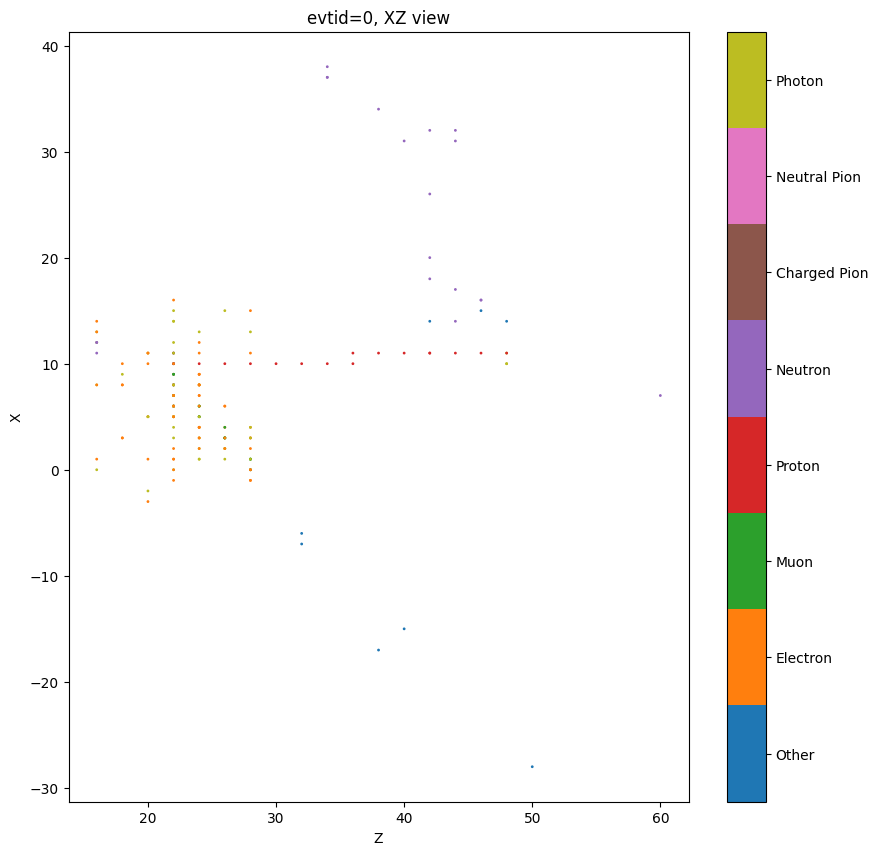

In [15]:
plot_view(classes, coords, prongs, view="XZ")

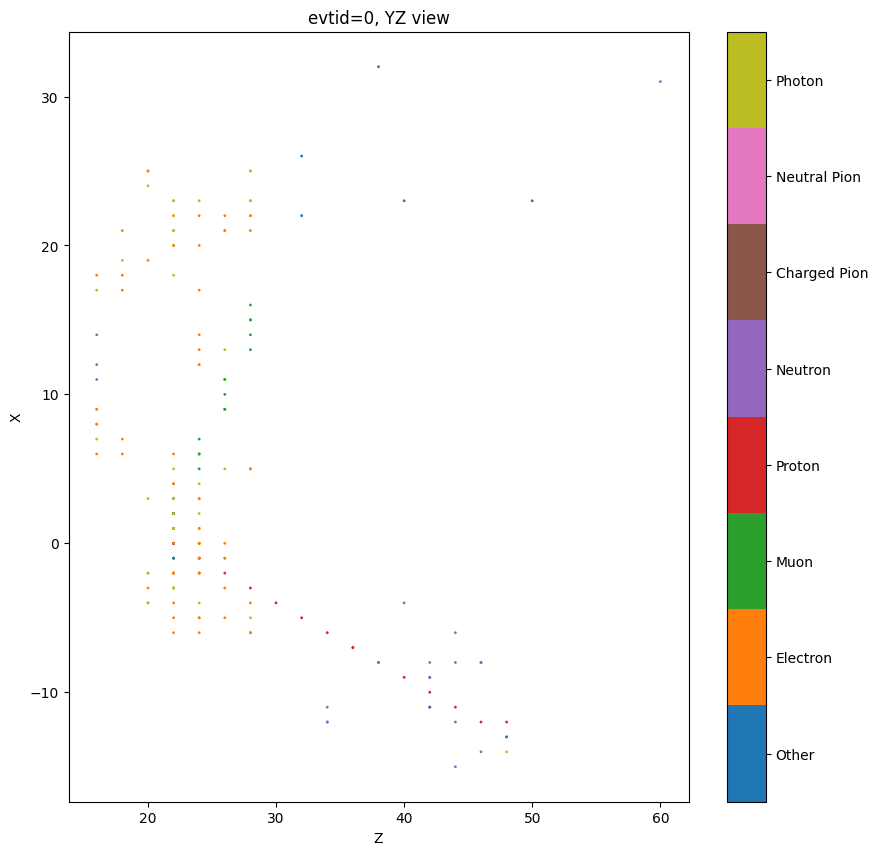

In [16]:
plot_view(classes, coords, prongs, view="YZ")

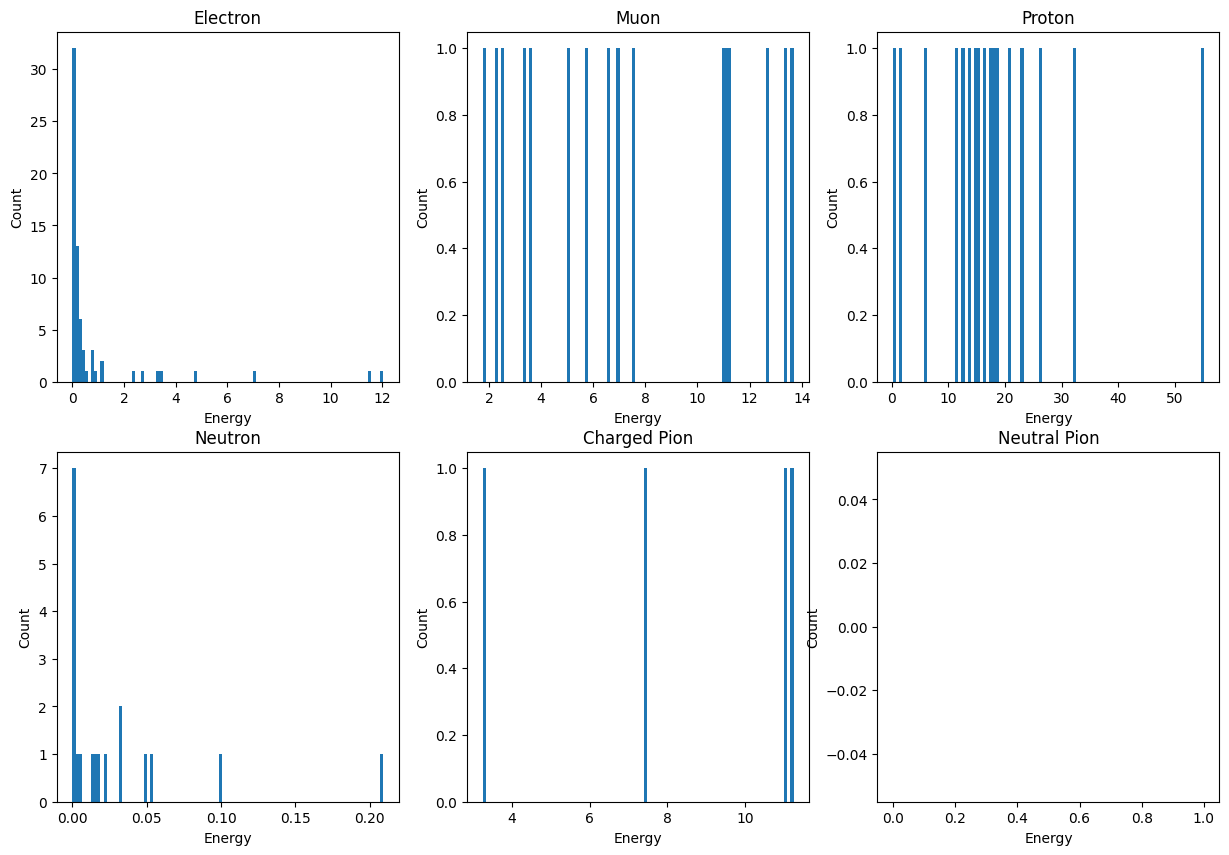

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axs = axs.ravel()
for i in range(1,7):
    axs[i-1].set_title(list(class_names.keys())[i])
    axs[i-1].hist(edep[classes==i], bins=100)
    axs[i-1].set_xlabel("Energy")
    axs[i-1].set_ylabel("Count")
plt.show()